In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer

full_data = pd.read_csv("Files/intraDataFile1F.csv", index_col=False)

#Cleaning cells
full_data = full_data.mask(full_data < 0, np.nan) #set -1 values to NaN

# Engenharia de Atributos

In [2]:
mod_data = full_data

#Changing Pos values

mod_data[['PosY']] = (mod_data[['PosY']]/mod_data[['PosY']].max())
mod_data[['PosX']] = (mod_data[['PosX']]/mod_data[['PosX']].max())

#Extracting categorical features

data = full_data[['BestMode']] 

for dta in data:
    cod = LabelBinarizer()
    cod.fit(data[dta])
    
    #generate header column list
    classes = cod.classes_.tolist() 
    column_name = []
    for num in classes:
        column_name.append(dta + str(num))
        
    binarized = cod.transform(data[dta])    
    onehot = pd.DataFrame(binarized, columns=list(column_name)) #create DF with binarized features headers             
    mod_data = pd.concat([mod_data,onehot], axis=1).drop([dta], axis=1)  

In [3]:
mod_data.to_csv("Files/modIntraData.csv")

# Modelo DC/PLANAR

- RMD list weights: Max(score DC/Planar), where score is 8, 7, 6, ..., 1  (min 8,7,6)
- MPM list weights: DC/Planar modes count, i.e., 0 | 1 | 2
- RMD costs: Min (DC cost, Planar cost)
- Label: isBestMode (boolean), i.e., if DC/Planar

In [4]:
m1_dataset = full_data
m1_dataset = m1_dataset.drop(['Frame','coCost','BestMode'], axis=1)
m1_dataset = m1_dataset.drop(m1_dataset.loc[:,'MPM1':], axis=1)

#Create new features
MPM = mod_data.filter(regex='MPM')
RMD = mod_data.filter(regex='RMD')

def RMD_weight(x):
    score = 0
    for i in range(8):
        if x[i] == 0 or x[i] == 1:
            if score <= i:
                score = 8-i
    return score;

def MPM_weight(x):
    weight = 0
    for i in range(3):
        if x[i] == 0 or x[i] == 1:
            weight += 1
    return weight 
    
m1_dataset['MPMWeight'] = MPM.apply(MPM_weight, axis=1)
m1_dataset['RMDWeight'] = RMD.apply(RMD_weight, axis=1)
m1_dataset['M1RMDCost'] = mod_data[['Cost0', 'Cost1']].min(axis=1)
m1_dataset['isBestMode'] = full_data['BestMode'].apply(lambda x: True if x == 0 or x == 1 else False)
for col in m1_dataset:        
    m1_dataset[col].fillna(m1_dataset[col].mean(), inplace=True) #fill NaN cells with average value of column  
    
m1_dataset

,PosY,PosX,Size,BestModeCost,Variance,AboveCost,LeftCost,AboveLeftCost,AboveRightCost,MPMWeight,RMDWeight,M1RMDCost,isBestMode
0,0.0,0.0,0,11891.300,32.703400,1365.821196,1357.967226,1361.747867,1340.753945,2,8,11891.300,True
1,0.0,0.0,1,3976.420,40.139400,1365.821196,1357.967226,1361.747867,1340.753945,2,8,3976.420,True
2,0.0,0.0,2,1871.340,6.211760,1365.821196,1357.967226,1361.747867,1340.753945,2,8,1871.340,True
3,0.0,0.0,3,1116.260,0.190476,1365.821196,1357.967226,1361.747867,1340.753945,2,8,1116.260,True
4,0.0,0.0,4,2289.080,0.190476,1365.821196,1357.967226,1361.747867,1340.753945,2,8,2289.080,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
461027,1.0,1.0,3,278.817,5.015870,578.542000,226.817000,1068.900000,1340.753945,1,2,528.725,False
461028,1.0,1.0,4,447.359,5.015870,235.817000,157.817000,144.817000,235.817000,1,6,513.267,False
461029,1.0,1.0,4,159.817,5.015870,235.817000,447.359000,235.817000,429.359000,1,6,226.725,False
461030,1.0,1.0,4,142.817,5.015870,447.359000,134.817000,157.817000,159.817000,0,0,226.725,False


# Separação dos modelos

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier


train, test = train_test_split(m1_dataset, test_size=0.2)
print(f"Size of training dataset: {len(train)}, Size of testing dataset: {len(test)}")

y_train = train['isBestMode']
x_train = train.drop('isBestMode', axis=1)

#Do training
model = DecisionTreeClassifier(random_state=0, criterion="entropy", max_depth=20)
trained_model = model.fit(x_train,y_train)

Size of training dataset: 368825, Size of testing dataset: 92207


In [6]:
count_true = np.count_nonzero(m1_dataset['isBestMode'] == True)
count_false = np.count_nonzero(m1_dataset['isBestMode'] == False)

display(count_true/(count_true+count_false))

0.47532926130941017

# Avaliação

Model accuracy: 0.9538755192122074


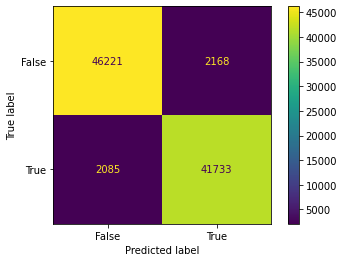

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

y_test = test['isBestMode']
x_test = test.drop('isBestMode', axis=1)

predict = trained_model.predict(x_test)
score = accuracy_score(y_test,predict)
print(f"Model accuracy: {score}")

plot_confusion_matrix(trained_model, x_test, y_test)

In [8]:
from sklearn.model_selection import cross_val_score

y = m1_dataset['isBestMode']
x = m1_dataset.drop('isBestMode', axis=1)

scores = cross_val_score(trained_model,x,y,cv=20)
print("Average Accuracy: ", scores.mean())

Average Accuracy:  0.8424584604110571


In [9]:
trained_model.feature_importances_

array([0.00630666, 0.00286192, 0.00141533, 0.20785363, 0.00537891,
       0.00444521, 0.00473937, 0.00391975, 0.00315582, 0.10582804,
       0.49722328, 0.15687208])

In [11]:
import m2cgen
import joblib

output = m2cgen.export_to_c(trained_model)
joblib.dump(trained_model,"trained_model.pkl")

['trained_model.pkl']

In [12]:
output_file = open("trained_model.c", "w")
output_file.write(output)
output_file.close

<function TextIOWrapper.close()>